# Texture-Based Optical Guided Despeckling of SAR Image

In [ ]:
import os
# os.environ['JAX_PLATFORM_NAME'] = 'cpu'

import jax
import jax.numpy as jnp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Tuple, List
import time

from scripts.texture_descriptor import compute_texture_descriptor, rgb2gray, rgb2lab, compute_similarity_map
from scripts.filters import gaussian_kernel_2d
from scripts.despeckling import UBF, DUBF
from scripts.utils import extract_patches, compute_indices_from_n_blocks

print(jax.devices())

[cuda(id=0)]


In [2]:
opt = Image.open('/home/nus/Downloads/optical_sar_data/optical.png')
sar = Image.open('/home/nus/Downloads/optical_sar_data/sar.png')

opt_rgb = jnp.array(opt) / 255.0
sar = jnp.array(sar) / 255.0
sar = jnp.expand_dims(sar, axis=-1)  # (H, W, 1)

opt_gray = rgb2gray(opt_rgb)
opt_lab = rgb2lab(opt_rgb)

print(sar.shape, opt_gray.shape, opt_lab.shape)

2025-08-08 11:57:49.885295: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.8 which is older than the ptxas CUDA version (12.9.86). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


(256, 256, 1) (256, 256, 1) (256, 256, 3)


In [3]:
radius = 21

time_start = time.time()
S = compute_texture_descriptor(opt_lab, radius)
time_end = time.time()
print(f"{time_end - time_start:.4f} seconds")

3.8754 seconds


### UBF

In [4]:
L = opt_gray

ubf = UBF()
time_start = time.time()
S_ubf, error = ubf.filter(S, L, sigma_s=5, sigma_l=0.05, alpha_ubf=2, n_iter=30, n_blocks=2)
time_end = time.time()
print(f"{time_end - time_start:.4f} seconds")

UBF Iterations: 100%|██████████| 30/30 [00:10<00:00,  2.77it/s]

11.3598 seconds


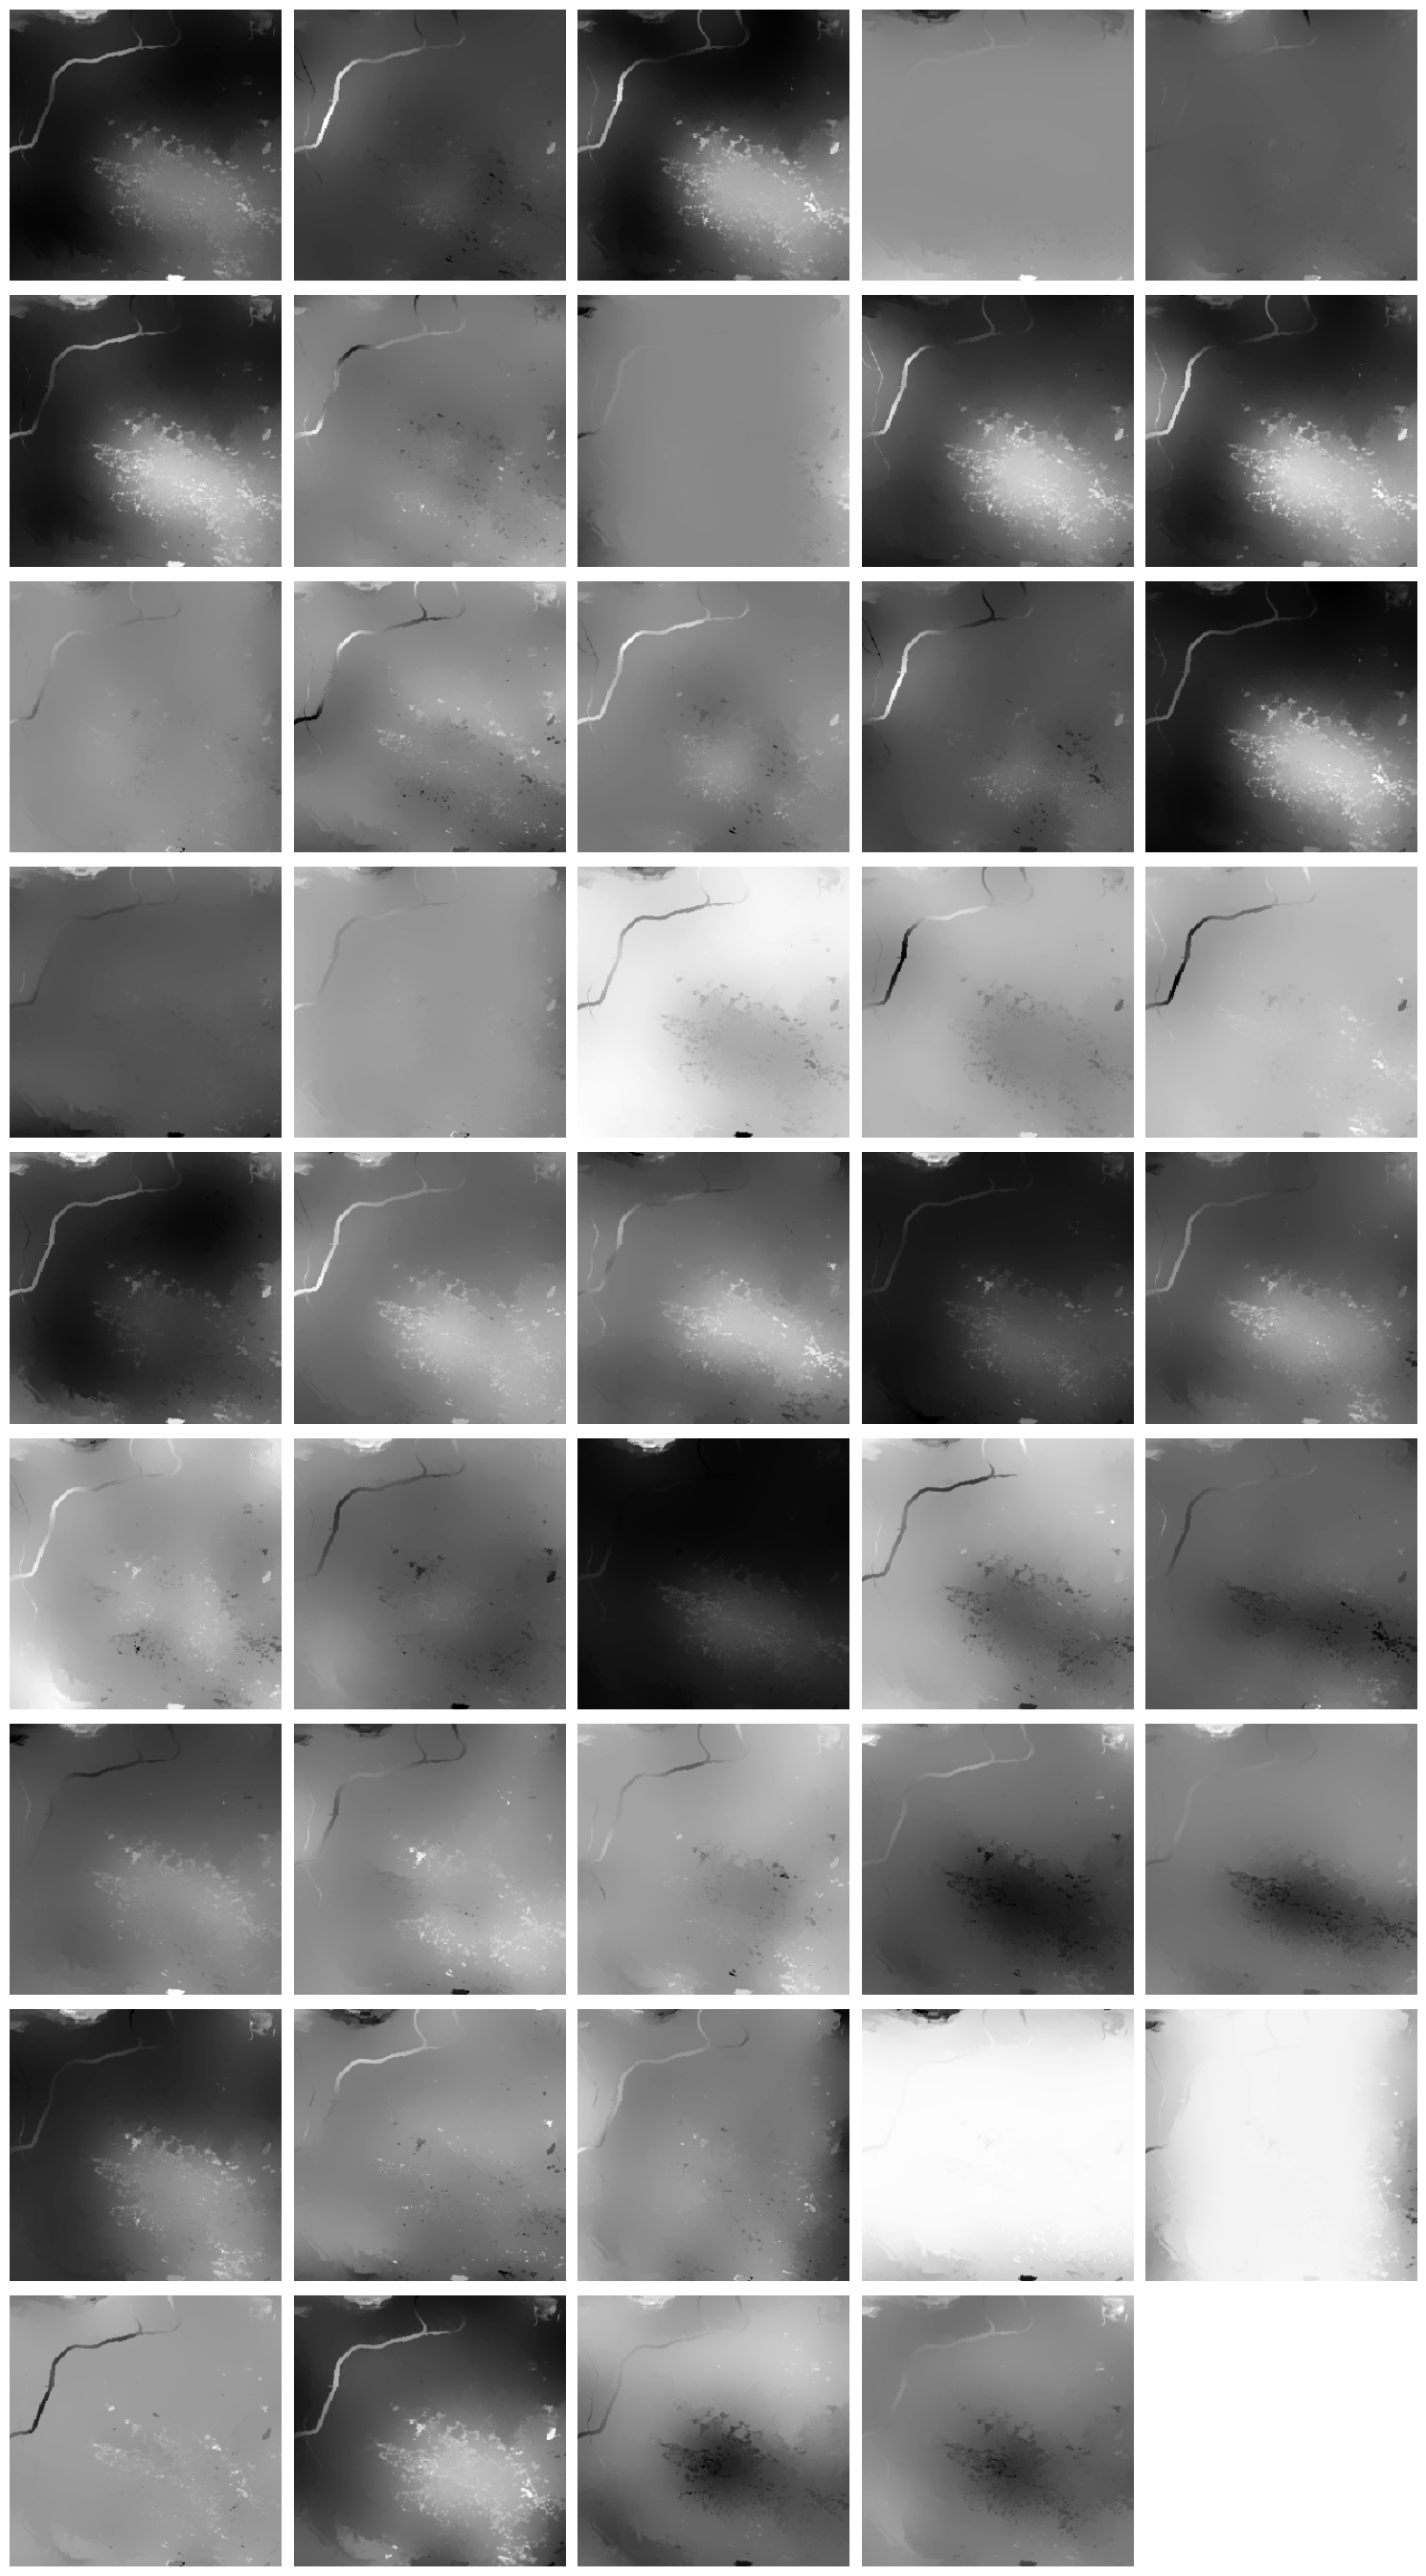

In [5]:
D = S_ubf.shape[-1]

N = 5  # Number of columns for plotting
plt.figure(figsize=(N * 3, (D // N + 1) * 3))
for i in range(D):
    plt.subplot(D // N + 1, N, i + 1)
    plt.imshow(S_ubf[:,:,i], cmap='gray')
    plt.axis('off')
plt.tight_layout()

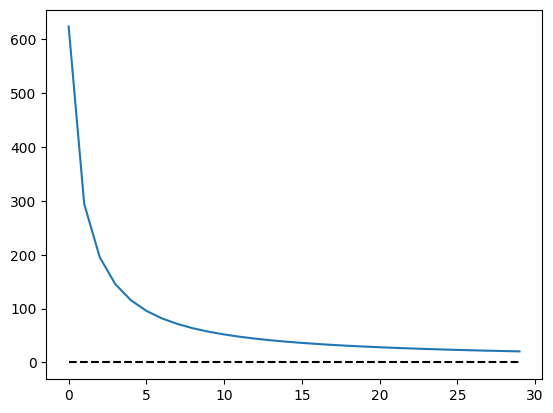

In [6]:
plt.plot(error)
plt.plot(np.arange(len(error)), np.zeros_like(error), 'k--')

### DUBF

In [7]:
L_opt = opt_gray
L_sar = sar  # (H, W, 1)

dubf = DUBF()
time_start = time.time()
S_dubf, error = dubf.filter(S, L_opt, L_sar, sigma_s=5, sigma_l_opt=0.1, sigma_l_sar=0.1, alpha_ubf=2, n_iter=30, n_blocks=2)
time_end = time.time()
print(f"{time_end - time_start:.4f} seconds")

DUBF Iterations: 100%|██████████| 30/30 [00:10<00:00,  2.88it/s]

10.4989 seconds


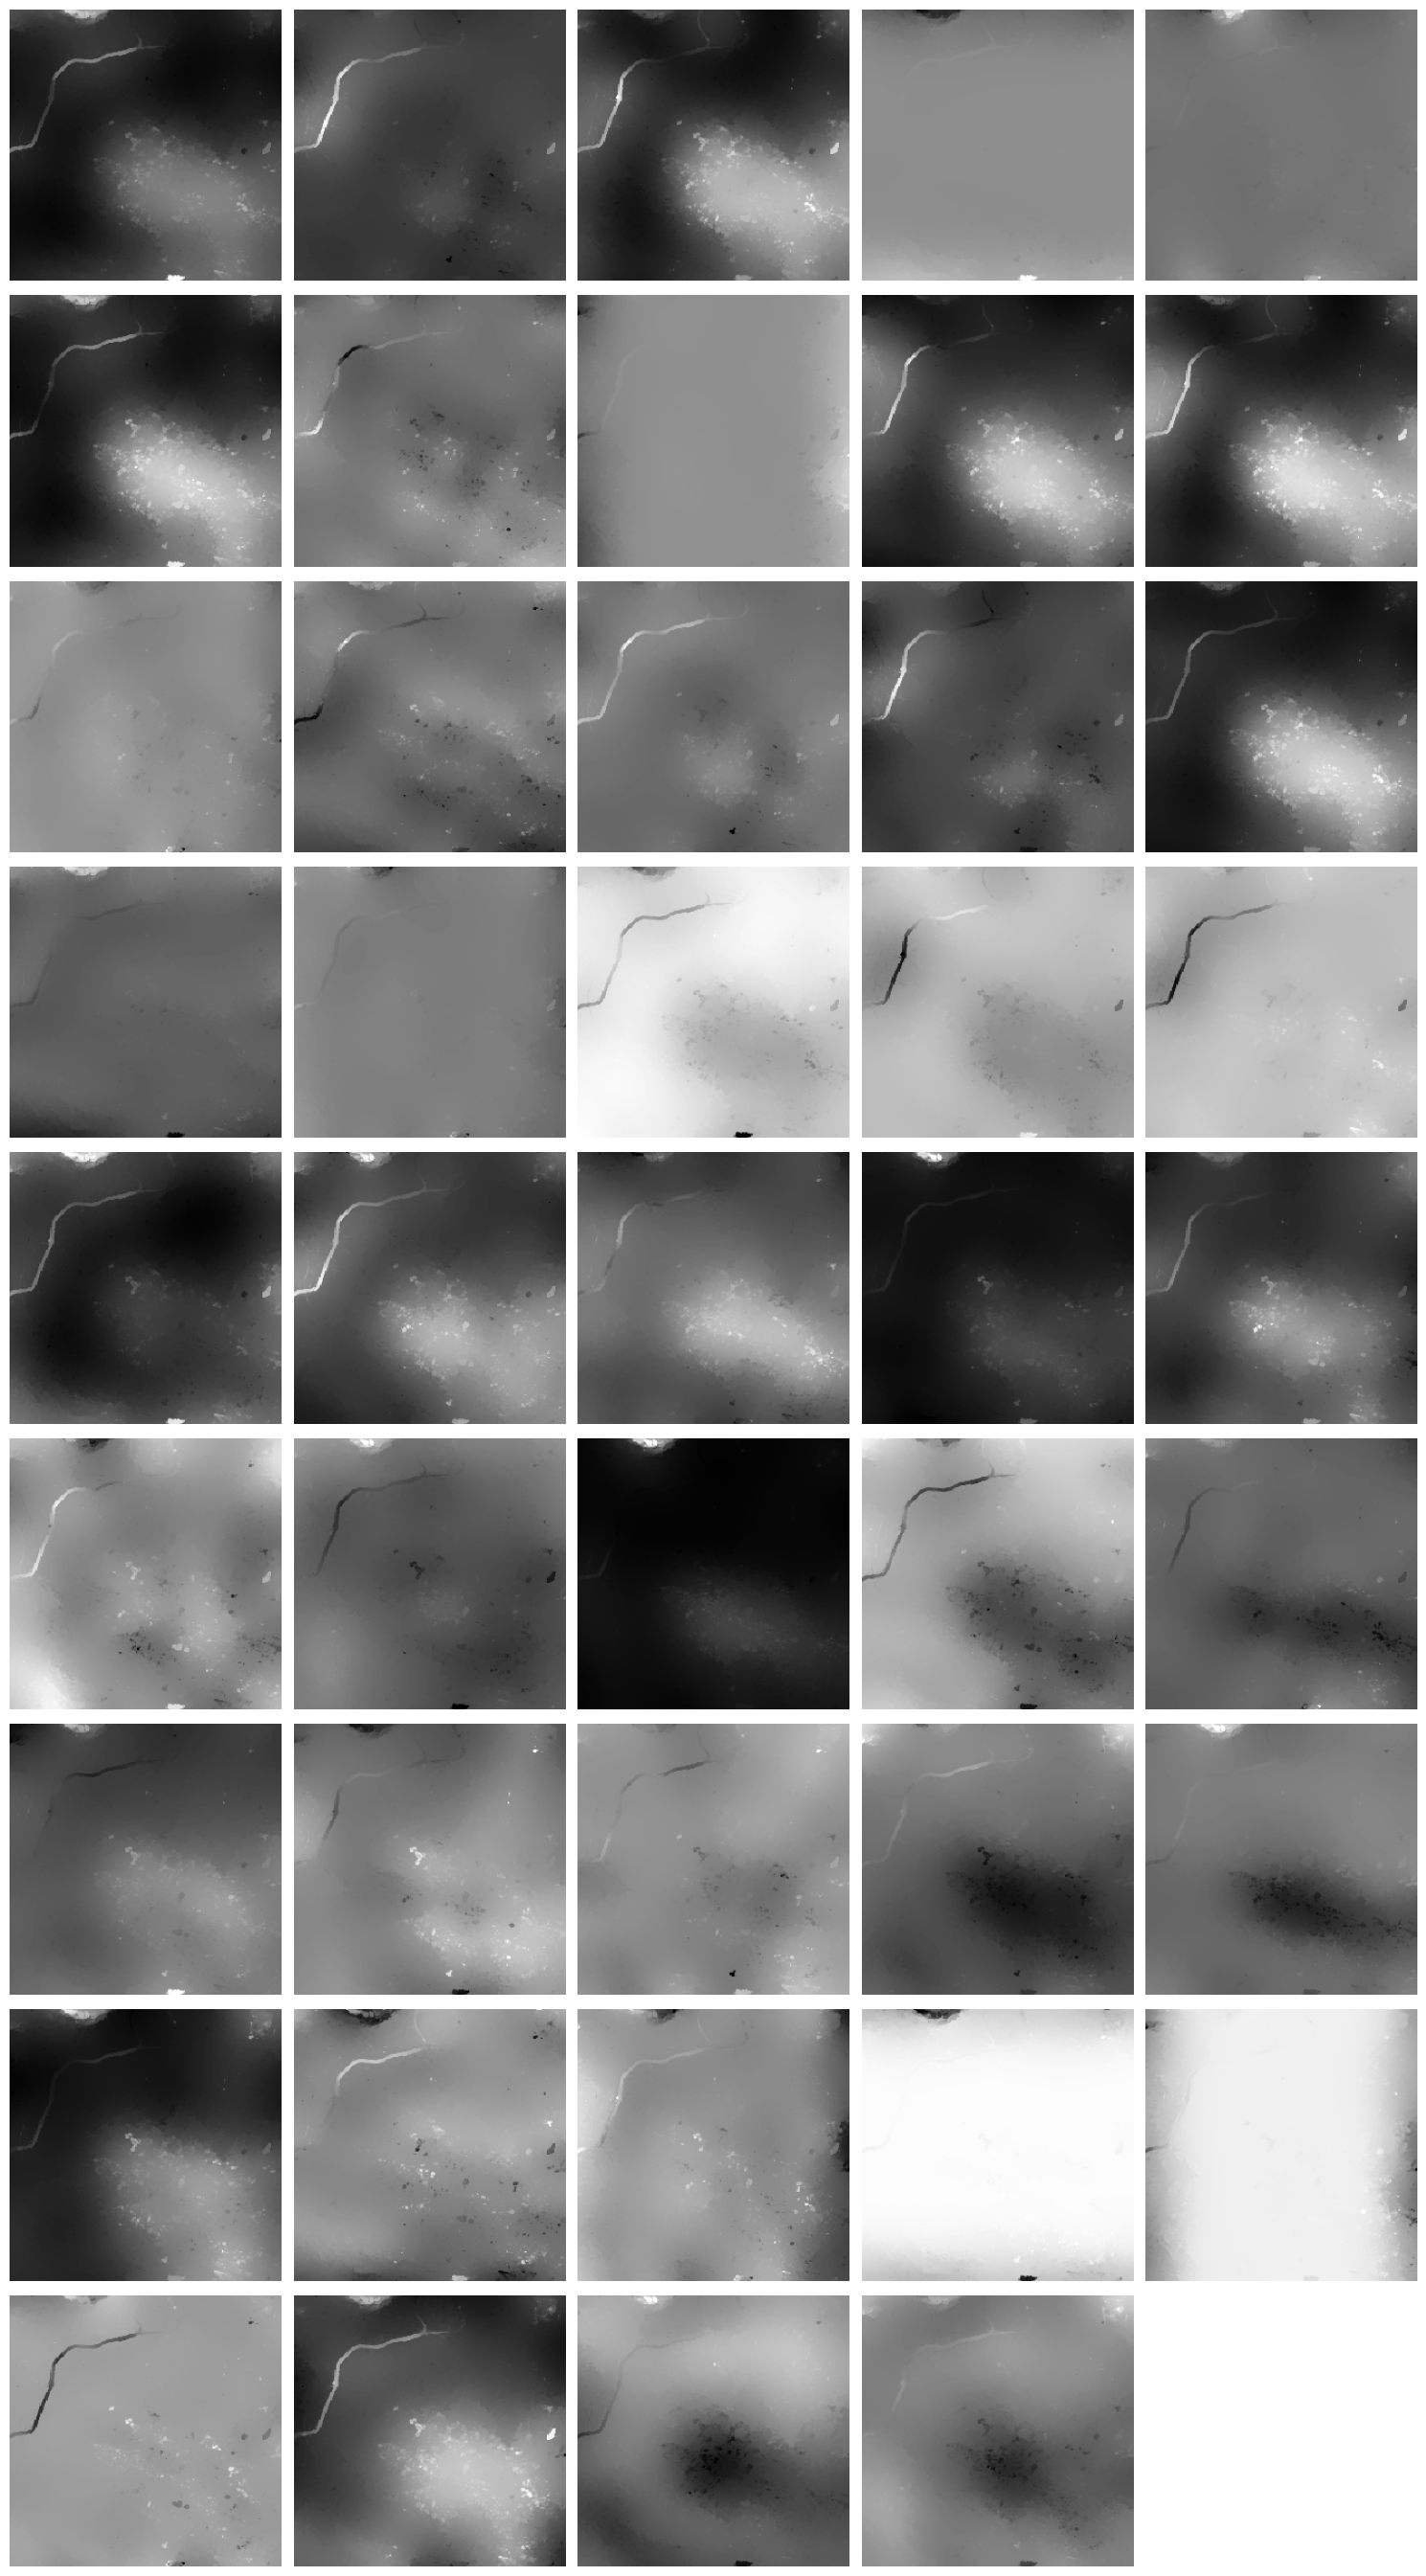

In [8]:
D = S_dubf.shape[-1]

N = 5  # Number of columns for plotting
plt.figure(figsize=(N * 3, (D // N + 1) * 3))
for i in range(D):
    plt.subplot(D // N + 1, N, i + 1)
    plt.imshow(S_dubf[:,:,i], cmap='gray')
    plt.axis('off')
plt.tight_layout()

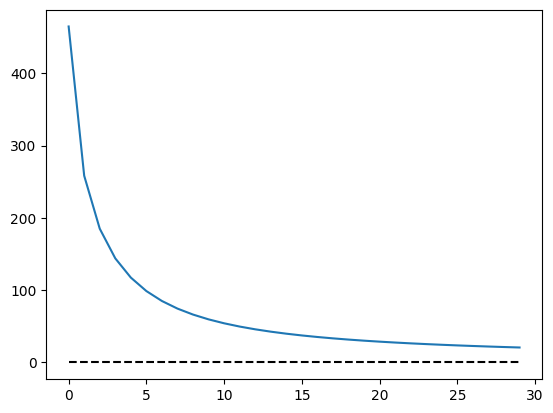

In [9]:
plt.plot(error)
plt.plot(np.arange(len(error)), np.zeros_like(error), 'k--')

### Despeckle

In [10]:
def despeckle(sar: jnp.ndarray, descriptor: jnp.ndarray, 
             sigma_d: float = 4) -> jnp.ndarray:
    """
    Despeckle SAR image using dual unnormalized bilateral filter.

    Parameters
    ----------
    sar : jnp.ndarray
        SAR image (H, W, C)
    descriptor : jnp.ndarray
        Texture descriptor (H, W, D)
    sigma_s : float
        Spatial standard deviation for the Gaussian kernel.
    sigma_l_opt : float
        Luminance standard deviation for optical image.
    sigma_l_sar : float
        Luminance standard deviation for SAR image.
    alpha_ubf : float
        Scaling factor for the update step.
    n_iter : int
        Number of iterations.

    Returns
    -------
    jnp.ndarray
        Despeckled SAR image (H, W, C)
    """
    return NotImplementedError

(256, 256)


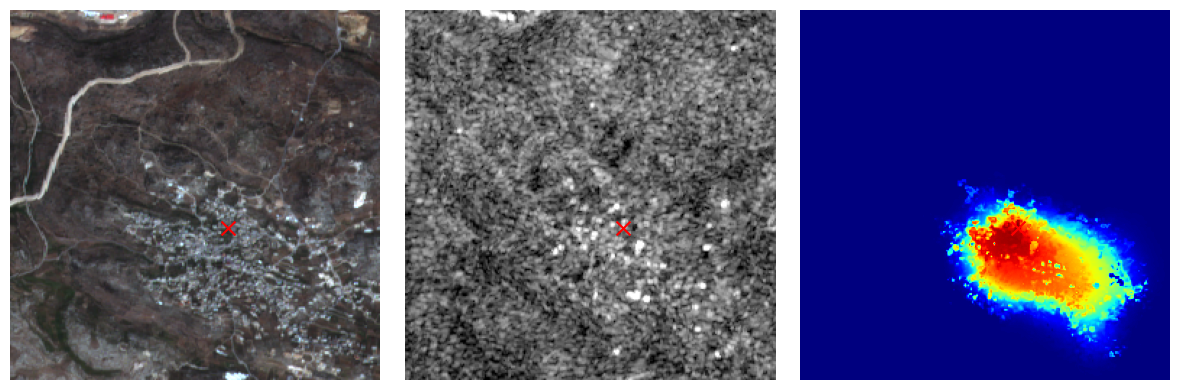

In [11]:
i, j = 150, 150  # width, height -> x, y
sigma_d = 3

similarity_map = compute_similarity_map(S_dubf[j, i, :], S_dubf, sigma_d=sigma_d)  # y, x
print(similarity_map.shape)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(opt)
plt.scatter(i, j, c='r', s=100, marker='x')  # x, y
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(sar, cmap='gray')
plt.scatter(i, j, c='r', s=100, marker='x')  # x, y
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(similarity_map, cmap='jet')
plt.scatter(i, j, c='r', s=100, marker='x')  # x, y
plt.axis('off')
plt.tight_layout()

(256, 256)


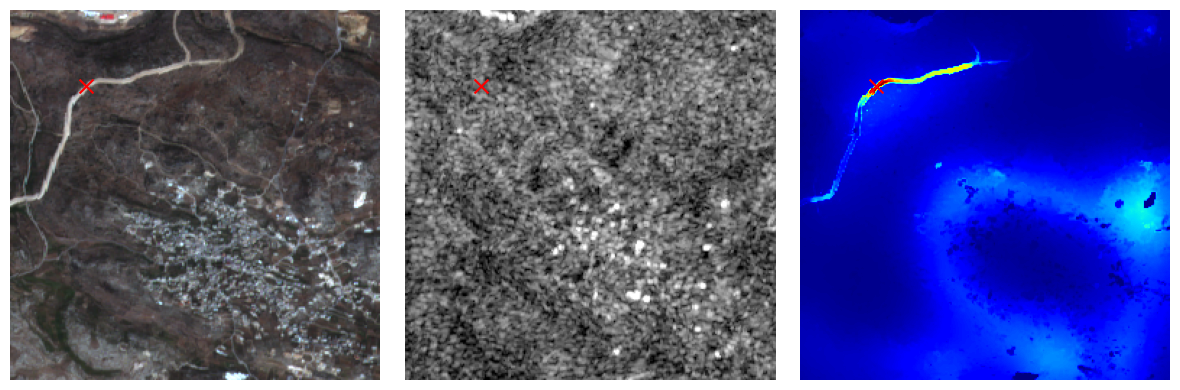

In [12]:
i, j = 52, 52  # width, height -> x, y
sigma_d = 5

similarity_map = compute_similarity_map(S_dubf[j, i, :], S_dubf, sigma_d=sigma_d)  # y, x
print(similarity_map.shape)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(opt)
plt.scatter(i, j, c='r', s=100, marker='x')  # x, y
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(sar, cmap='gray')
plt.scatter(i, j, c='r', s=100, marker='x')  # x, y
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(similarity_map, cmap='jet')
plt.scatter(i, j, c='r', s=100, marker='x')  # x, y
plt.axis('off')
plt.tight_layout()

In [ ]:
def compute_estimate(img: jnp.ndarray, similarity_map: jnp.ndarray) -> None:
    numerator = (img * similarity_map).sum()
    mu_p = numerator / (similarity_map.sum())
    return mu_p


def despeckle(S: jnp.ndarray, sar: jnp.ndarray, sigma_d: float = 0.005, window_size: int = 15, n_blocks: int = 10) -> jnp.ndarray:
    H, W = S.shape[0], S.shape[1]
    sar_filtered = sar.copy() 
    
    # Compute start and end indices for memory efficiency
    start_indices, end_indices = compute_indices_from_n_blocks(n_blocks, H, W, padding=0)

    # Iterate over the blocks
    for start_index, end_index in zip(start_indices, end_indices):
        # Extract windows (patches) for all spatial locations
        S_patches = extract_patches(sar, kernel_size, start_index, end_index)   # (H', W', H, W, D)
        S_p = S[j, i, :]

        # Compute similarity map (distance in feature space)
        similarity_map = compute_similarity_map(S_p, S, sigma_d=sigma_d)  # (H, W)
        
        # Compute filtered value
        mu_p = compute_estimate(sar.squeeze(), similarity_map)
        sar_filtered = sar_filtered.at[j, i].set(mu_p)

    return sar_filtered

In [18]:
sigma_d = 0.5
window_size = 50
tau = 0.1

time_start = time.time()
sar_filtered = despeckle(S_dubf, sar, sigma_d=sigma_d, window_size=window_size, tau=tau)
time_end = time.time()
print(f"{time_end - time_start:.4f} seconds")

TypeError: despeckle() got an unexpected keyword argument 'window_size'

In [19]:
def despeckle(S: jnp.ndarray, sar: jnp.ndarray, sigma_d: float = 0.005, window_size: int = 15, tau: float = 0.9) -> jnp.ndarray:
    H, W = S.shape[0], S.shape[1]
    sar_filtered = sar.copy() 
    speed_up_mask = jnp.zeros((H, W), dtype=bool)

    progress_bar = tqdm(total=H*W, desc='Filtering', unit='pixel')
    for j in range(H):
        for i in range(W):
            if not speed_up_mask[j, i]:
                S_p = S[j, i, :]  # Extract the descriptor for the current pixel

                # Extract local window
                imin, imax = max(0, i - window_size // 2), min(W, i + window_size // 2 + 1)
                jmin, jmax = max(0, j - window_size // 2), min(H, j + window_size // 2 + 1)
                S_patch = S[jmin:jmax, imin:imax, :]
                sar_patch = sar[jmin:jmax, imin:imax, :]

                # Compute similarity map (distance in feature space)
                similarity_map = compute_similarity_map(S_p, S_patch, sigma_d=sigma_d)[..., None]  # Add channel dimension

                # Compute filtered value
                numerator = (sar_patch * similarity_map).sum()
                mu_p = numerator / (similarity_map.sum())
                
                # Apply filtered value
                speed_up_indices = jnp.where(similarity_map > tau)

                for idx in range(len(speed_up_indices[0])):
                    j_idx, i_idx = speed_up_indices[0][idx], speed_up_indices[1][idx]
                    sar_filtered = sar_filtered.at[j_idx, i_idx].set(mu_p)
                    speed_up_mask = speed_up_mask.at[j_idx, i_idx].set(True)
                # sar_filtered = sar_filtered.at[j, i].set(mu_p)

            progress_bar.update(1)
    progress_bar.close()
    return sar_filtered

In [20]:
sigma_d = 0.5
window_size = 50
tau = 0.1

time_start = time.time()
sar_filtered = despeckle(S_dubf, sar, sigma_d=sigma_d, window_size=window_size, tau=tau)
time_end = time.time()
print(f"{time_end - time_start:.4f} seconds")

Filtering:   0%|          | 169/65536 [01:03<16:34:07,  1.10pixel/s]

KeyboardInterrupt: 